In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from datetime import datetime
import joblib

expense_data = pd.read_csv("~/Downloads/Expense Sheet - Categorized.csv");
expense_data.rename(columns = {'head':'Head', 'category':'Category'}, inplace = True)

heads = ['date', 'Head', 'comment', 'amount', 'Category']
additional_train_datas = [
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), 'diesel', '', 0.0, 'Fuel')],
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), 'Ac fitting', '', 0.0, 'Appliances')],
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), '2 ACs', '', 0.0, 'Appliances')],
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), 'Air Condition', '', 0.0, 'Appliances')],
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), 'Printout', '', 0.0, 'Education')],
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), 'Coconut water', '', 0.0, 'Grocery')],
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), 'paintor', '', 0.0, 'Maintenance')]
]
for additional_train_data in additional_train_datas:
    additional_train_data_df = pd.DataFrame.from_records(additional_train_data, columns=heads)
    expense_data = pd.concat([expense_data, additional_train_data_df], ignore_index=True)

    print(expense_data)
#expense_data.head


#X = expense_data.drop(columns=['date', 'amount', 'comment', 'Category']);
#y = expense_data['Category'];
#X.head



                     date            Head  \
0     2019-06-18T18:47:30           T est   
1     2019-06-18T19:35:05      Vegetables   
2     2019-06-18T20:03:44   Bathla ladder   
3     2019-06-18T20:05:52     Vegetables    
4     2019-06-18T20:06:09          Pizza    
...                   ...             ...   
5580  2025-04-20T11:26:37  Coconut water    
5581  2025-04-20T15:53:14        Dentist    
5582  2025-04-20T19:06:31          Fruits   
5583  2025-04-20T19:16:41            Milk   
5584  2025-04-21T07:04:56          diesel   

                                                comment  amount      Category  
0                                                   NaN     0.0         Other  
1                                                   NaN   430.0       Grocery  
2                                                   NaN  2199.0     Household  
3                                                   NaN   405.0       Grocery  
4                                                   NaN   3

In [2]:
expense_data['category_id'] = expense_data['Category'].factorize()[0]
category_id_expense = expense_data[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_expense.values)
id_to_category = dict(category_id_expense[['category_id', 'Category']].values)
expense_data

,date,Head,comment,amount,Category,category_id
0,2019-06-18T18:47:30,T est,NaN,0.0,Other,0
1,2019-06-18T19:35:05,Vegetables,NaN,430.0,Grocery,1
2,2019-06-18T20:03:44,Bathla ladder,NaN,2199.0,Household,2
3,2019-06-18T20:05:52,Vegetables,NaN,405.0,Grocery,1
4,2019-06-18T20:06:09,Pizza,NaN,310.0,Food Outside,3
...,...,...,...,...,...,...
5586,2025-04-21T07:04:56,2 ACs,,0.0,Appliances,16
5587,2025-04-21T07:04:56,Air Condition,,0.0,Appliances,16
5588,2025-04-21T07:04:56,Printout,,0.0,Education,7
5589,2025-04-21T07:04:56,Coconut water,,0.0,Grocery,1


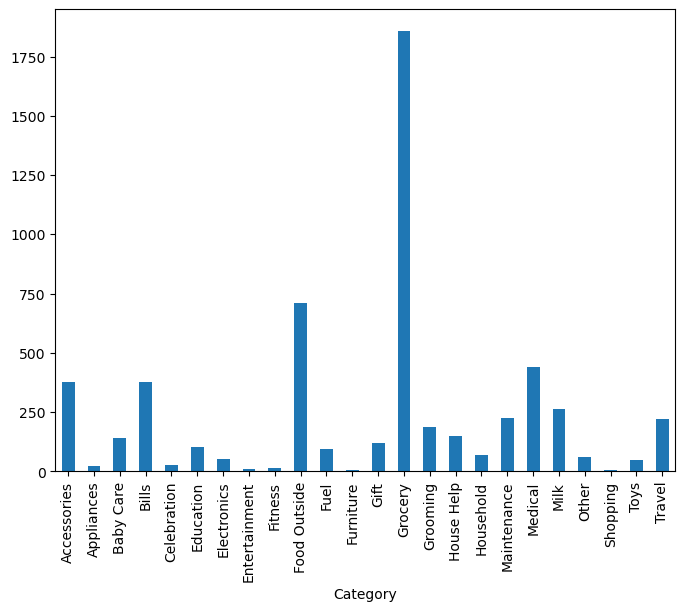

In [3]:
fig = plt.figure(figsize=(8,6))
expense_data.groupby('Category').Head.count().plot.bar(ylim=0)
plt.show()

In [4]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(expense_data.Head).toarray()
labels = expense_data.category_id
features.shape

(5591, 233)

In [5]:
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Accessories':
  . Most correlated unigrams:
. accessories
. shopping
  . Most correlated bigrams:
. baby dress
. cuckoo dress
# 'Appliances':
  . Most correlated unigrams:
. machine
. washing
  . Most correlated bigrams:
. mobile recharge
. washing machine
# 'Baby Care':
  . Most correlated unigrams:
. diapers
. baby
  . Most correlated bigrams:
. baby wipes
. baby care
# 'Bills':
  . Most correlated unigrams:
. broadband
. mobile
  . Most correlated bigrams:
. netflix recharge
. mobile recharge
# 'Celebration':
  . Most correlated unigrams:
. chocolate
. celebration
  . Most correlated bigrams:
. doctor consultation
. mobile recharge
# 'Education':
  . Most correlated unigrams:
. xerox
. book
  . Most correlated bigrams:
. mobile recharge
. school fee
# 'Electronics':
  . Most correlated unigrams:
. battery
. electronics
  . Most correlated bigrams:
. mobile recharge
. mobile cover
# 'Entertainment':
  . Most correlated unigrams:
. entertainment
. movie
  . Most correlated bigrams:

In [6]:
#expense_data['HeadAndCommentAndAmount'] = expense_data['Head'].astype(str) + '-' + expense_data['Comment'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(
    expense_data['Head'], expense_data['Category'], test_size=.001, random_state = 0
)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = LogisticRegression(fit_intercept=False).fit(X_train_tfidf, y_train)
#clf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0).fit(X_train_tfidf, y_train)
#clf = MultinomialNB().fit(X_train_tfidf, y_train)
#clf = LinearSVC().fit(X_train_tfidf, y_train)

y_predicted = clf.predict(X_train_tfidf)
print(metrics.classification_report(y_train, y_predicted))

               precision    recall  f1-score   support

  Accessories       1.00      1.00      1.00       377
   Appliances       1.00      0.96      0.98        23
    Baby Care       0.98      1.00      0.99       142
        Bills       1.00      1.00      1.00       375
  Celebration       0.97      0.97      0.97        29
    Education       0.99      1.00      1.00       104
  Electronics       0.94      0.98      0.96        51
Entertainment       1.00      1.00      1.00        11
      Fitness       1.00      1.00      1.00        13
 Food Outside       1.00      1.00      1.00       709
         Fuel       1.00      1.00      1.00        94
    Furniture       0.88      1.00      0.93         7
         Gift       1.00      1.00      1.00       122
      Grocery       1.00      1.00      1.00      1854
     Grooming       0.99      1.00      1.00       186
   House Help       1.00      0.98      0.99       150
    Household       0.94      0.94      0.94        71
  Mainten

In [7]:
results = clf.predict(count_vect.transform(["Shipper"]))
#prob_per_class_dictionary = dict(zip(model.classes_, results))

print(results)

['Household']


In [8]:
joblib.dump(clf, '/Users/aloksingh/git/expense-catecorization/expense-categorization-mdl.joblib');

In [9]:
joblib.dump(count_vect, '/Users/aloksingh/git/expense-catecorization/expense-categorization-vct.joblib');

In [10]:
clf_LSVC = LinearSVC().fit(X_train_tfidf, y_train)

y_predicted = clf_LSVC.predict(X_train_tfidf)
print(metrics.classification_report(y_train, y_predicted))

/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


               precision    recall  f1-score   support

  Accessories       1.00      1.00      1.00       377
   Appliances       1.00      1.00      1.00        23
    Baby Care       1.00      1.00      1.00       142
        Bills       1.00      1.00      1.00       375
  Celebration       1.00      1.00      1.00        29
    Education       1.00      1.00      1.00       104
  Electronics       1.00      1.00      1.00        51
Entertainment       1.00      1.00      1.00        11
      Fitness       1.00      1.00      1.00        13
 Food Outside       1.00      1.00      1.00       709
         Fuel       1.00      1.00      1.00        94
    Furniture       1.00      1.00      1.00         7
         Gift       1.00      1.00      1.00       122
      Grocery       1.00      1.00      1.00      1854
     Grooming       1.00      1.00      1.00       186
   House Help       1.00      1.00      1.00       150
    Household       1.00      1.00      1.00        71
  Mainten

In [11]:
results = clf_LSVC.predict(count_vect.transform(["Aquarium"]))

print(results)

['Household']


In [12]:
joblib.dump(clf_LSVC, '/Users/aloksingh/git/expense-catecorization/expense-categorization-LSVC-mdl.joblib');

In [13]:
clf_MNB = MultinomialNB().fit(X_train_tfidf, y_train)

y_predicted = clf_MNB.predict(X_train_tfidf)
print(metrics.classification_report(y_train, y_predicted))

               precision    recall  f1-score   support

  Accessories       0.98      0.96      0.97       377
   Appliances       0.00      0.00      0.00        23
    Baby Care       0.98      0.84      0.90       142
        Bills       0.97      1.00      0.99       375
  Celebration       1.00      0.03      0.07        29
    Education       1.00      0.72      0.84       104
  Electronics       1.00      0.27      0.43        51
Entertainment       0.00      0.00      0.00        11
      Fitness       0.00      0.00      0.00        13
 Food Outside       0.95      1.00      0.98       709
         Fuel       1.00      0.95      0.97        94
    Furniture       0.00      0.00      0.00         7
         Gift       0.97      0.86      0.91       122
      Grocery       0.85      0.99      0.91      1854
     Grooming       0.99      0.89      0.94       186
   House Help       1.00      0.94      0.97       150
    Household       1.00      0.15      0.27        71
  Mainten

/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
clf_RFC = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0).fit(X_train_tfidf, y_train)

y_predicted = clf_RFC.predict(X_train_tfidf)
print(metrics.classification_report(y_train, y_predicted))

               precision    recall  f1-score   support

  Accessories       0.00      0.00      0.00       377
   Appliances       0.00      0.00      0.00        23
    Baby Care       0.00      0.00      0.00       142
        Bills       0.00      0.00      0.00       375
  Celebration       0.00      0.00      0.00        29
    Education       0.00      0.00      0.00       104
  Electronics       0.00      0.00      0.00        51
Entertainment       0.00      0.00      0.00        11
      Fitness       0.00      0.00      0.00        13
 Food Outside       0.00      0.00      0.00       709
         Fuel       0.00      0.00      0.00        94
    Furniture       0.00      0.00      0.00         7
         Gift       0.00      0.00      0.00       122
      Grocery       0.33      1.00      0.50      1854
     Grooming       0.00      0.00      0.00       186
   House Help       0.00      0.00      0.00       150
    Household       0.00      0.00      0.00        71
  Mainten

/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/a

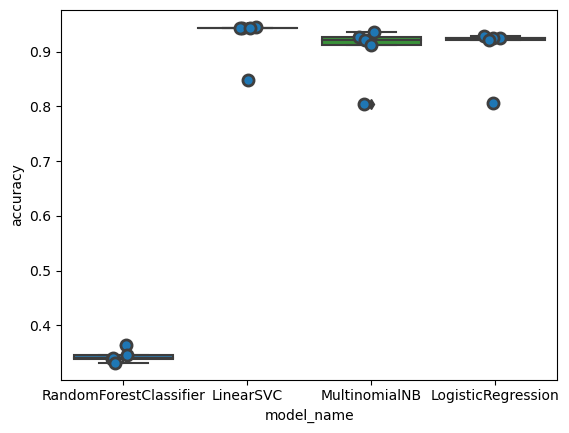

In [15]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(fit_intercept=False),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [16]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.924356
LogisticRegression        0.901287
MultinomialNB             0.900393
RandomForestClassifier    0.344304
Name: accuracy, dtype: float64

/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


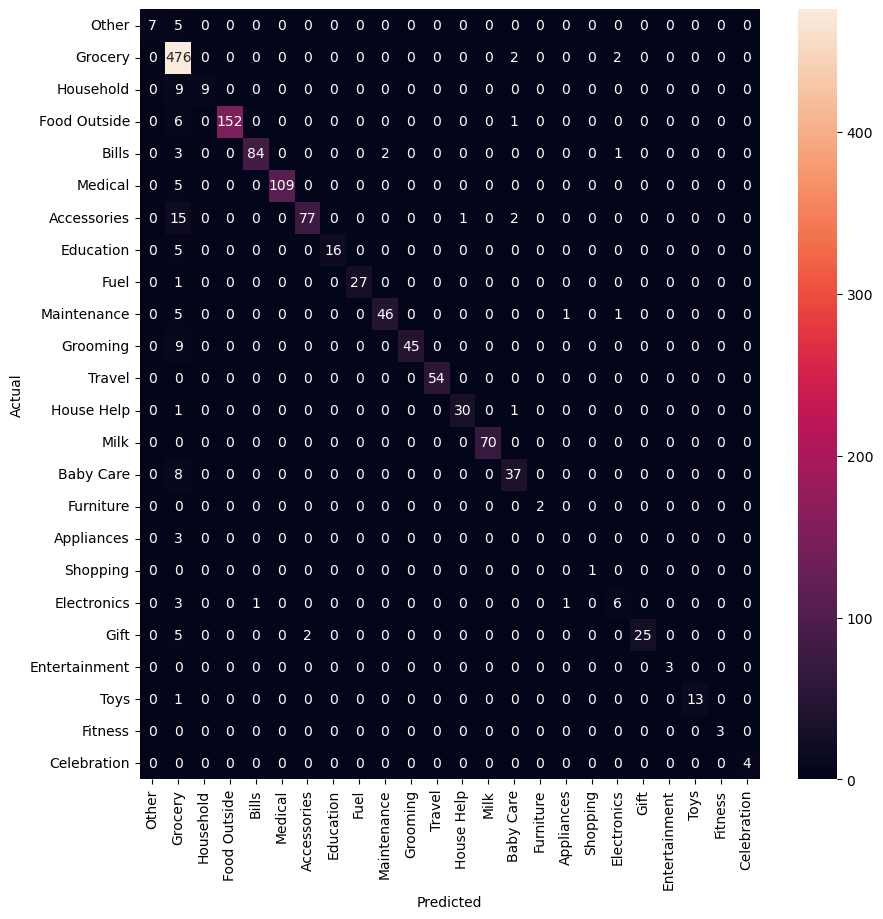

In [17]:
#model = LogisticRegression(fit_intercept=False)
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, expense_data.index, test_size=0.25, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_expense.Category.values, yticklabels=category_id_expense.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [18]:
import neptune
import neptune.integrations.sklearn as npt_utils

run = neptune.init_run(
    project="home-stack/ExpenseCategorization",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwNTYyODcyOC1kZDMxLTQyMWUtOWM1NS04MmM0NDQ1NmNjYjkifQ==",
)  # your credentials

# Neptune integration with scikit-learn works with
# the regression and classification problems as well.
# Check the user guide in the documentation for more details:
# https://docs.neptune.ai/integrations/sklearn
run["classifier"] = npt_utils.create_classifier_summary(
    model, X_train, X_test, y_train, y_test
)

run.stop()

ImportError: cannot import name 'DEPRECATED_SERVICE_NAMES' from 'botocore.docs' (/Users/aloksingh/anaconda3/lib/python3.11/site-packages/botocore/docs/__init__.py)

In [ ]:
import neptune
model_version = neptune.init_model_version(
    model="EXCAT-EXCAT",
    project="home-stack/ExpenseCategorization",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwNTYyODcyOC1kZDMxLTQyMWUtOWM1NS04MmM0NDQ1NmNjYjkifQ==", # your credentials
)

model_version["model"].upload('/Users/aloksingh/git/expense-catecorization/expense-categorization-LSVC-mdl.joblib')
#model_version["validation/dataset"].track_files("s3://datasets/validation")
#model_version["validation/acc"] = 0.97

model_version.change_stage("staging")

In [ ]:
#pd.options.display.float_format = '{:,.2f}'.format
#test_data = pd.read_csv("~/Downloads/Expense Sheet - Categorized.csv").drop(columns=['Timestamp', 'Amount', 'Month', 'Year', 'Category', 'Comment']);
test_data = pd.read_csv("~/Downloads/Expense Sheet - Categorized.csv")
test_data.head()
print()

#expense_data['category_id'] = expense_data['Category'].factorize()[0]
#clf.predict(count_vect.transform(list(test_data)))
#test_data['predicted'] = clf.predict(test_data['Head'].factorize()[0])

#test_data.groupby(['predicted']).sum()
#test_data.groupby(['predicted']).sum().plot.pie( subplots=True,figsize=(5, 5))

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
corpus = ['this is the first document',
          'this document is the second document',
          'and this is the third one',
          'is this the first document']
vocabulary = ['this', 'document', 'first', 'is', 'second', 'the',
              'and', 'one']
pipe = Pipeline([('count', CountVectorizer(vocabulary=vocabulary)),
                 ('tfid', TfidfTransformer())]).fit(corpus)
pipe['count'].transform(corpus).toarray()


In [ ]:
pipe['tfid'].idf_
pipe.transform(corpus).shape